# AI-ClientProject-4 --> Quora Question Pairs

### PROJECT GOAL
##### Create a model that can predict which of the provided pairs of questions contain two questions with the same meaning.

In [19]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Installing libraries which are needed for loading, processing, and modeling our question-pair data.
!pip install -q pandas numpy scikit-learn sentence-transformers

In [54]:
# 📦 Data Handling
import pandas as pd
import numpy as np

# 🧮 Utility Tools
from tqdm import tqdm  # Progress bar for loops
import warnings        # Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 🤗 Text Embedding / Feature Extraction
from sentence_transformers import SentenceTransformer

# 🧠 Similarity Calculation
from sklearn.metrics.pairwise import cosine_similarity

# 📊 Model Training and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 💾 Model Persistence
import joblib

In [22]:
#This step loads and reduces the dataset to a manageable size and ensures data quality.
df = pd.read_csv("/content/drive/MyDrive/AI CAPSTONE PROJECT/Client Project/train.csv") #Load the data
df = df.sample(20000, random_state=42) #Randomly selects 20,000 rows to make training faster.
df = df.dropna() #Removes rows with missing values (essential to avoid errors during training).
df = df[['question1', 'question2', 'is_duplicate']] #Keeps only the relevant columns.
df.head() #Displays the first 5 rows (useful for inspection).

,question1,question2,is_duplicate
8067,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,How close we are to see 3rd world war?,How close is a World War III?,1


In [23]:
#Counts how many duplicate vs. non-duplicate pairs exist
df['is_duplicate'].value_counts()

,count
is_duplicate,
0,12606
1,7394


<Axes: xlabel='is_duplicate'>

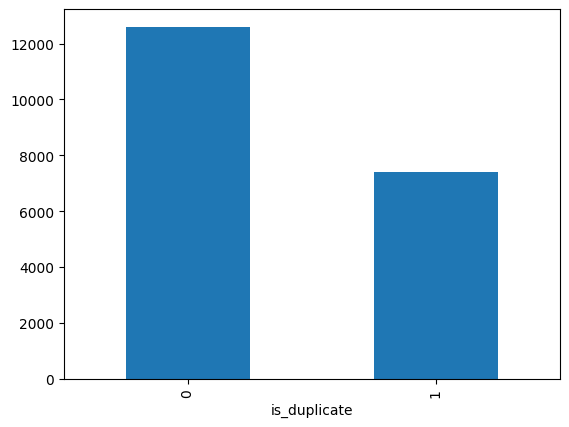

In [24]:
#Bar plot showing how many duplicate (1) vs. non-duplicate (0) question pairs exist.
df['is_duplicate'].value_counts().plot(kind='bar')

In [25]:
#This step transforms each question pair into numerical features that can be fed to a machine learning model.
embedder = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
def extract_features(q1, q2):
    # 🔤 Generate sentence embeddings
    vec1 = embedder.encode([q1])
    vec2 = embedder.encode([q2])

    # 📏 Compute cosine similarity between embeddings
    cos_sim = cosine_similarity(vec1, vec2)[0][0]

    # 🔡 Token-based features
    tokens1 = set(q1.lower().split())
    tokens2 = set(q2.lower().split())

    # 🔁 Common words ratio
    common_words_ratio = len(tokens1 & tokens2) / max(len(tokens1 | tokens2), 1)

    # 📏 Absolute character length difference
    abs_len_diff = abs(len(q1) - len(q2))

    return [cos_sim, common_words_ratio, abs_len_diff]

In [27]:
# Extract features
features = []
for q1, q2 in tqdm(zip(df['question1'], df['question2']), total=len(df)):
    features.append(extract_features(q1, q2))

100%|██████████| 20000/20000 [1:31:16<00:00,  3.65it/s]


In [28]:
# Convert to DataFrame
X = pd.DataFrame(features, columns=["cos_sim", "common_words_ratio", "abs_len_diff"])
y = df['is_duplicate'].values

In [68]:
#Splits data into 80% training and 20% testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Training the Model
model = LogisticRegression(class_weight='balanced')  # better for imbalanced dataset
#Fits the model on the training data.
model.fit(X_train, y_train)
y_pred = model.predict(X_test) #Predicts on the test set

## **Model Evaluation**

In [78]:
print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n F1 Score:", f1_score(y_test, y_pred))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 0.8085

 F1 Score: 0.7745732783990583

 Confusion Matrix:
 [[1918  578]
 [ 188 1316]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.77      0.83      2496
           1       0.69      0.88      0.77      1504

    accuracy                           0.81      4000
   macro avg       0.80      0.82      0.80      4000
weighted avg       0.83      0.81      0.81      4000



In [79]:
# Save model
joblib.dump(model, '/content/drive/MyDrive/AI CAPSTONE PROJECT/Client Project/best_model.pkl')

['/content/drive/MyDrive/AI CAPSTONE PROJECT/Client Project/best_model.pkl']

In [80]:
# Load model
my_model = joblib.load('/content/drive/MyDrive/AI CAPSTONE PROJECT/Client Project/best_model.pkl')

In [81]:
def predict_duplicate(q1, q2):
    """
    Predict whether two questions are duplicates using the trained model.
    """
    # Extract features and reshape for model input
    features = np.array(extract_features(q1, q2)).reshape(1, -1)

    # Predict using the trained model
    pred = my_model.predict_proba(features)[0][1]
    label = "Duplicate" if pred >= 0.5 else "Not Duplicate"

    # Return human-readable result
    return f"{label} (Confidence Value: {pred:.2f})"


## **Testing The Performance Of Our Model**
##### Note: - If Confidence Value is below 0.5 then the Model will Predict the result as not Duplicate

In [82]:
print(predict_duplicate("How can I be a good programmer?", "What should I do to become a great coder?"))

Duplicate (Confidence Value: 0.70)


In [83]:
print(predict_duplicate("How can I be a good software engineer?", "What are the tips to become a successful software engineer?"))

Duplicate (Confidence Value: 0.89)


In [84]:
print(predict_duplicate("How can I be a good software engineer?", "What are the tips to become a successful data engineer?"))

Not Duplicate (Confidence Value: 0.29)


In [85]:
print(predict_duplicate("Is photosynthesis same as respiration?", "Is respiration same as photosynthesis?"))

Duplicate (Confidence Value: 0.94)


In [86]:
examples = [
    ("How can I learn machine learning?", "What is the best way to study machine learning?"),
    ("What is the capital of France?", "Where is the Eiffel Tower located?"),
    ("How do I cook pasta?", "What is the recipe to boil pasta?"),
    ("What are some good books to read?", "Can you suggest me a playlist of top songs?"),
    ("Why is the sky blue?", "Why does the sky appear blue in color?")
]

# Run predictions
for q1, q2 in examples:
    result = predict_duplicate(q1, q2)
    print(f"Q1: {q1}\nQ2: {q2}\n→ Prediction: {result}\n")

Q1: How can I learn machine learning?
Q2: What is the best way to study machine learning?
→ Prediction: Duplicate (Confidence Value: 0.81)

Q1: What is the capital of France?
Q2: Where is the Eiffel Tower located?
→ Prediction: Not Duplicate (Confidence Value: 0.21)

Q1: How do I cook pasta?
Q2: What is the recipe to boil pasta?
→ Prediction: Duplicate (Confidence Value: 0.80)

Q1: What are some good books to read?
Q2: Can you suggest me a playlist of top songs?
→ Prediction: Not Duplicate (Confidence Value: 0.01)

Q1: Why is the sky blue?
Q2: Why does the sky appear blue in color?
→ Prediction: Duplicate (Confidence Value: 0.79)



## **Testing on Custom User Input**

In [52]:
# User Input Test
q1 = input("Enter the first question: ")
q2 = input("Enter the second question: ")

result = predict_duplicate(q1, q2)
print("The questions are:", result)

Enter the first question: How close we are to see 4th world war?
Enter the second question: How close is a World War IV?
The questions are: Duplicate (Confidence Value: 0.80)
